The code in this notebook was inspired and partially copied/derived from these articles:

https://towardsdatascience.com/lime-vs-shap-which-is-better-for-explaining-machine-learning-models-d68d8290bb16

LIME vs. SHAP: Which is Better for Explaining Machine Learning Models?
Two of the most popular Explainers compared
Dario Radečić, Dec 14, 2020

https://towardsdatascience.com/squeezing-more-out-of-lime-with-python-28f46f74ca8e
Squeezing More out of LIME with Python
How to create global aggregations of LIME weights
Conor O'Sullivan, May 4 2022

However many of the features do not work for MLP.

 **Dataset (Q1):** The Iris dataset, a renowned pattern recognition dataset by R.A. Fisher, comprises 150 instances representing three types of iris plants: Iris-Setosa, Iris-Versicolour, and Iris-Virginica. It features four numeric attributes—sepal length, sepal width, petal length, and petal width—measured in centimeters. The dataset serves as a classic benchmark in pattern recognition, containing both linearly separable and non-separable instances. With balanced class distribution and summary statistics, including notable variation in petal length and width, it remains a fundamental reference in machine learning literature since its introduction in 1936, referenced for its historical significance and value in the field.

[ https://scikit-learn.org/stable/datasets/toy_dataset.html](https://)

In [78]:
import numpy as np
import pandas as pd
from sklearn.datasets import load_iris
#Download iris dataset as a DataFrame
raw_data = load_iris(as_frame=True)
iris_data = raw_data.frame


#Remove target Variable
iris_data['class']=iris_data['target'].map(lambda ind: raw_data['target_names'][ind])
iris_data= iris_data.drop('target', axis=1)

type(iris_data)
print(iris_data.info())
print(iris_data.describe())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   class              150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB
None
       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000          3.000000           4.350000   
75%             6.400000          3.300000      

In [79]:
# Display the first five rows of the dataset
print(iris_data.head())

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

    class  
0  setosa  
1  setosa  
2  setosa  
3  setosa  
4  setosa  


In [80]:
# Checking distribution of the class variable to check if the dataset is balanced or unbalanced
print(iris_data.groupby("class").size())

class
setosa        50
versicolor    50
virginica     50
dtype: int64


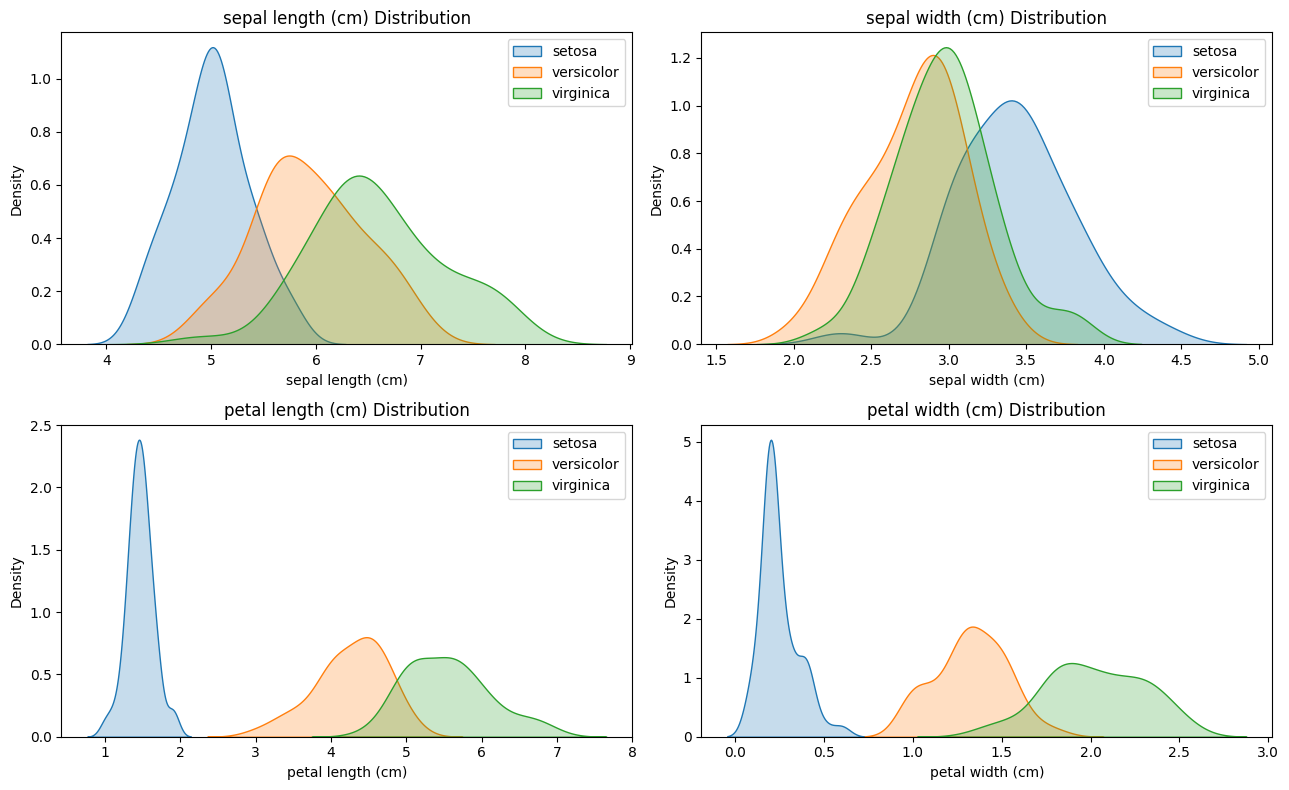

In [81]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting density curves for each variable
features = ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
setosa = 'setosa'
versicolor = 'versicolor'
virginica = 'virginica'

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(13, 8))

for i, feature in enumerate(features):
    row = i // 2
    col = i % 2
    ax = axes[row, col]
    sns.kdeplot(iris_data[iris_data['class'] == setosa][feature], label=setosa, ax=ax, fill=True)
    sns.kdeplot(iris_data[iris_data['class'] == versicolor][feature], label=versicolor, ax=ax, fill=True)
    sns.kdeplot(iris_data[iris_data['class'] == virginica][feature], label=virginica, ax=ax, fill=True)
    ax.set_xlabel(feature)
    ax.set_ylabel('Density')
    ax.set_title(f'{feature} Distribution')
    ax.legend()

# Displaying the plots
plt.tight_layout()
plt.show()

                   sepal length (cm)  sepal width (cm)  petal length (cm)  \
sepal length (cm)           1.000000         -0.117570           0.871754   
sepal width (cm)           -0.117570          1.000000          -0.428440   
petal length (cm)           0.871754         -0.428440           1.000000   
petal width (cm)            0.817941         -0.366126           0.962865   

                   petal width (cm)  
sepal length (cm)          0.817941  
sepal width (cm)          -0.366126  
petal length (cm)          0.962865  
petal width (cm)           1.000000  


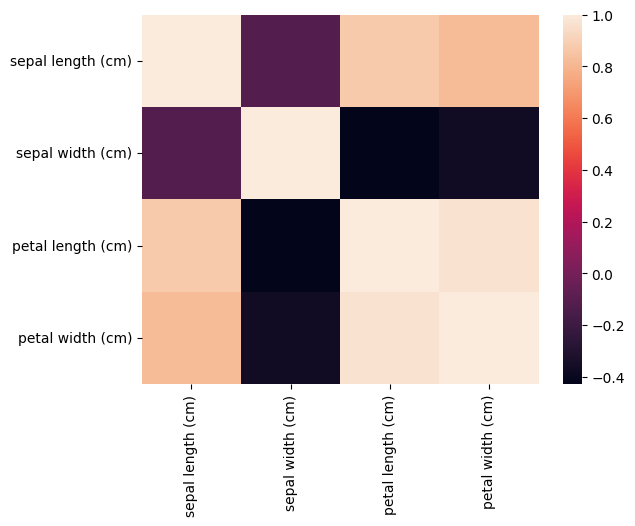

In [82]:
from sklearn.model_selection import train_test_split
#Set up input variables(X) and output variable(y)
X = iris_data.drop('class', axis=1)
y = iris_data['class']

import seaborn as sns
#We examine correlated input variables to see if we should drop any
cormat = X.corr()
round(cormat,2)

#print(cormat);
sns.heatmap(cormat);

# Display the correlation values.
pd.set_option('display.max_columns', None)  # Show all columns
print(cormat)


**EDA (Q4)**: In the previous part of the code, I conducted an exploratory analysis of the Iris dataset. The initial part showcased the first five rows of the dataset, followed by descriptive statistics and the distribution of classes, revealing an equal representation of each iris species. The main focus was on the density distribution plots that highlighted attribute distributions among Setosa, Versicolor, and Virginica species. Notably, petal length and width displayed distinct peaks with minimal overlap between species, aiding easy differentiation. Sepal length exhibited similar trends, albeit with some overlap. Conversely, sepal width showed substantial overlap, notably between Versicolor and Virginica. The code further explores attribute correlations using a heatmap. Notably, sepal length correlated positively with petal length (.87) and width (.81), indicating a tendency for them to increase together. Additionally, petal length and width exhibited a strong positive correlation (.96). This analysis provided valuable insights into the Iris dataset's characteristics and attribute distributions across different species. I did  not removed any feature for this model.

In [83]:
#Split data set into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [84]:

#Set the random number generation seed so that results can be duplicated
np.random.seed(12345)

#Fit a Neural Network model with the training data
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30), activation='relu', solver='adam', max_iter=20000)
mlp.fit(X_train.values,y_train)



MLPClassifier(hidden_layer_sizes=(30, 30, 30), max_iter=20000)

In [85]:
from sklearn.metrics import classification_report
#Provide quality of fit metrics with the test dataset
y_pred = mlp.predict(X_test)
target_names = set(raw_data['target_names'])
print(X_test.columns)
print(classification_report(y_test, y_pred, target_names=target_names))

Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



X has feature names, but MLPClassifier was fitted without feature names


In [86]:
!pip install lime
import lime
from lime import lime_tabular

#install Lime

test_1 = X_test.iloc[9]
print(test_1, y_pred[9])

lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=X_train.columns,
    class_names=['setosa', 'versicolor','virginica'],
    mode='classification'
)

#Explain one instance of the data with lime
lime_exp = lime_explainer.explain_instance(
    data_row=test_1,
    predict_fn=mlp.predict_proba
)
lime_exp.show_in_notebook(show_table=True)

sepal length (cm)    5.8
sepal width (cm)     2.7
petal length (cm)    3.9
petal width (cm)     1.2
Name: 82, dtype: float64 versicolor


In [87]:
!pip install shap
import shap
shap.initjs()
#Create a summary plot of the influence of all input variables on instance 10 of the test dataset
shap_explainer = shap.KernelExplainer(mlp.predict_proba, X_train)
shap_values = shap_explainer.shap_values(X_test.iloc[9,:])
shap.force_plot(shap_explainer.expected_value[0], shap_values[0], X_test.iloc[14,:])



In [88]:
shap.initjs()
shap_values = shap_explainer.shap_values(X_test)
#Now we show an interactive plot for all values/samples in the dataset

shap.force_plot(shap_explainer.expected_value[0], shap_values[0], X_test)

  0%|          | 0/30 [00:00<?, ?it/s]

**Compare and Contrast SHAP & Lime Explainers (Q7)**: In comparing the interpretability methods LIME and SHAP on the 10th instance of the dataset, there are notable differences in their outcomes. For the LIME method, the predicted probabilities for the three classes are displayed, with "versicolor" being the predicted class. This prediction is justified by specific attributes of the instance, as indicated by the importance scores assigned to each attribute. Notably, the attribute "petal length (cm)" stands out as a significant contributor to the prediction, indicated by a high score of 1.50, suggesting that this attribute strongly influences the prediction in favor of the "versicolor" class. Other attributes such as "sepal length (cm)" and "petal width (cm)" also contribute to the prediction but to a lesser extent.

On the other hand, the SHAP method provides an insightful visualization of attribute importance through the SHAP plot. In this specific instance, the SHAP plot reveals that the attribute "petal length (cm)" is represented predominantly in blue, indicating that this feature pushes the prediction lower towards the base value. Additionally, attributes such as "petal width (cm)" and "sepal width (cm)" are also depicted in blue, though to a lesser extent. This suggests that these attributes, while contributing positively to the prediction, have a relatively smaller impact compared to "petal length (cm)." This insight aligns with the LIME interpretation and strengthens the understanding that these attributes collectively influence the prediction in favor of the "versicolor" class. Furthermore, the SHAP force plot provides additional insights, indicating that the "petal length (cm)" attribute influences the prediction both positively and negatively, making it a primary driver of prediction variance.

In conclusion, the comparison between the LIME and SHAP interpretability methods on the 10th instance of the dataset reveals consistent findings regarding the influential attributes for predicting the "versicolor" class. LIME emphasizes these attributes' significance through importance scores and attribute comparisons, while SHAP provides a visual representation in the form of the SHAP plot. Both methods concur that the "petal length (cm)" attribute plays a pivotal role in driving the prediction towards the "versicolor" class. This alignment is reinforced by the prevalence of blue shading in the SHAP plot, signifying that "petal length (cm)," alongside "petal width (cm)" and "sepal width (cm)," collectively contributes to lowering the prediction towards the base value. The synergy between these two interpretability techniques underscores their complementary nature, allowing for a comprehensive understanding of attribute contributions and prediction dynamics.












Index(['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)',
       'petal width (cm)'],
      dtype='object')
30


Text(0.5, 0, 'Mean |Weight|')

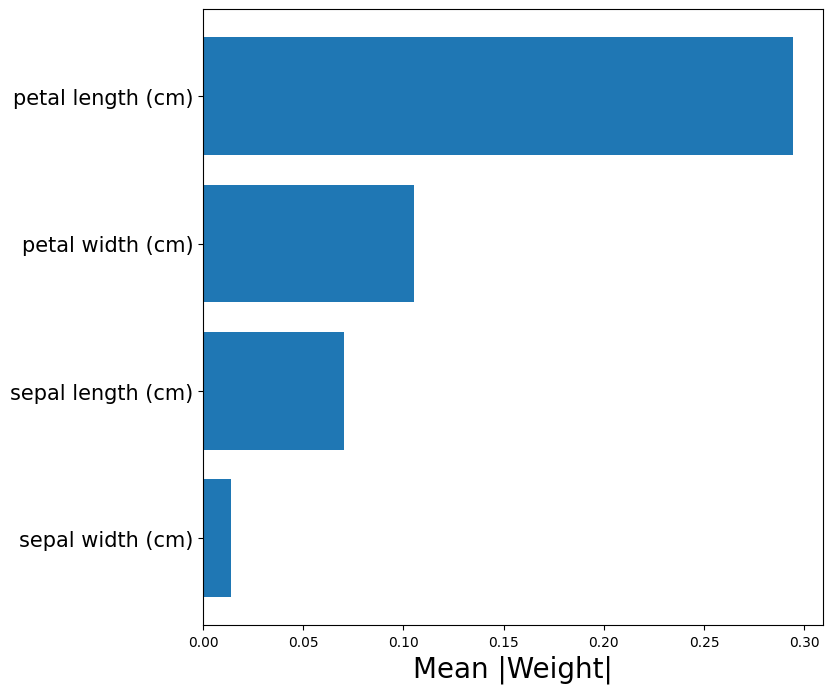

In [89]:
import matplotlib.pyplot as plt

weights = []

#Function to get weights from LIME explanation object
def return_weights(ep):
    exp_list = exp.as_map()[1]
    exp_list = sorted(exp_list, key=lambda x: x[0])
    exp_weight = [x[1] for x in exp_list]
    return exp_weight

print(X_test.columns)
print(len(X_test))

#Iterate over the rows in feature matrix
#and collect the LIME weights
#You can run for more elements----but we pick a max of 25
for x in range(min(len(X_test),25)):
    #Get explanation
    exp = lime_explainer.explain_instance(X_test.iloc[x],
                                 mlp.predict_proba, num_features = len(X_test.columns))
    #Get weights
    exp_weight = return_weights(exp)
    weights.append(exp_weight)

#Create DataFrame of the LIME weights
lime_weights = pd.DataFrame(data=weights,columns=X_test.columns)

#Get absolute value of the mean of LIME weights
abs_mean = lime_weights.abs().mean(axis=0)
abs_mean = pd.DataFrame(data={'feature':abs_mean.index, 'abs_mean':abs_mean})
abs_mean = abs_mean.sort_values('abs_mean')

#Plot abs mean LIME weights
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,8))

y_ticks = range(len(abs_mean))
y_labels = abs_mean.feature
plt.barh(y=y_ticks,width=abs_mean.abs_mean)

plt.yticks(ticks=y_ticks,labels=y_labels,size= 15)
plt.title('')
plt.ylabel('')
plt.xlabel('Mean |Weight|',size=20)

  0%|          | 0/30 [00:00<?, ?it/s]

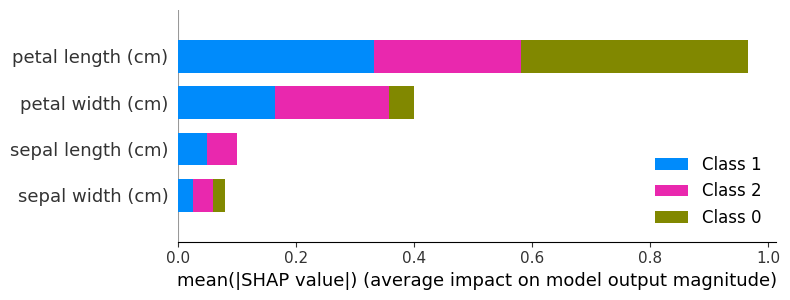

In [90]:
shap.initjs()
#Create a summary plot of the influence of all input variables on the test dataset
shap_explainer = shap.KernelExplainer(mlp.predict_proba, X_train)

shap_vals = shap_explainer.shap_values(X_test)

shap.summary_plot(shap_vals, X_test, max_display=X_test.shape[1])




**Summary Plots (Q8)**: The LIME Summary Plot of the Mean Weight reveals that the "petal length" attribute holds substantial weight in the prediction, making it the most influential feature. This is followed by "petal width," "sepal length," and finally, "sepal width." Moving on to the SHAP summary plot, a more comprehensive view emerges, illustrating the contribution of each feature to different classes and their impact on the model's output magnitude. The results in terms of influential variables align between LIME and SHAP, with "petal length" remaining the top contributor, followed by "petal width" and "sepal length." However, there are notable differences. In the SHAP summary plot, it is observed that for one of the classes (class 0, represented in green), "sepal length" does not significantly contribute to the prediction of that class. Additionally, for another class (class 2, represented in magenta), both "petal length" and "petal width" exhibit nearly equal magnitudes of contribution, with "petal length" having a slightly higher impact. This indicates that while both LIME and SHAP highlight "petal length" as a major influencer, SHAP provides a more nuanced view by showcasing the varying influences across different classes, ultimately enhancing our understanding of feature contributions to predictions.